In [1]:
import simglucose
from simglucose.simulation.scenario import CustomScenario
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from collections import namedtuple, deque
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import datetime as dt

In [2]:
# Filter out deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### Classes and Fuctions

In [3]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
def paper_reward_function(BG_last_hour):
    G = BG_last_hour[-1]
    if G >= 70 and G <= 180:
        return 0.5
    if G > 180 and G <= 200:
        return -0.9
    if G > 200 and G <= 250:
        return -1.2
    if G > 250 and G <= 350:
        return -1.5
    if G > 30 and G < 70:
        return -1.8
    else:
        return -2

In [5]:
def create_env(name):

    env = gym.make(name)

    env = FlattenObservation(env)

    return env

In [6]:
class DQNNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
class DDQNAgent:
    def __init__(
        self,
        input_size,
        output_size,
        gamma=0.95,
        learning_rate=0.001,
        buffer_size=800,
        batch_size=32,
    ):
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Epsilon-greedy exploration
        self.epsilon_start = 1.0
        self.epsilon_end = 0.1
        self.epsilon_decay_episodes = 30

        self.epsilon = self.epsilon_start

        # Q-networks
        self.q_network = DQNNetwork(input_size, output_size).to(self.device)
        self.target_q_network = DQNNetwork(input_size, output_size).to(self.device)
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # Optimizer
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Experience replay buffer
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=buffer_size)

    def select_action(self, state, env):
        if np.random.rand() < self.epsilon:
            action = env.action_space.sample()
        else:
            # Exploit: choose the action with the highest Q-value
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            action = q_values.argmax().item()

        return action

    # Update epsilon during training
    def update_epsilon(self, episode):
        # Linear decay from epsilon_start to epsilon_end over epsilon_decay_episodes
        self.epsilon = max(self.epsilon_end, self.epsilon_start - (episode / self.epsilon_decay_episodes))

    def store_transition(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.replay_buffer.append(transition)

    def sample_batch(self):
        batch = random.sample(
            self.replay_buffer, min(len(self.replay_buffer), self.batch_size)
        )
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and handle dimensions
        states = torch.stack([torch.FloatTensor(state) for state in states])
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.stack(
            [torch.FloatTensor(next_state) for next_state in next_states]
        )
        dones = torch.FloatTensor(dones).unsqueeze(1)

        return states, actions, rewards, next_states, dones

    def update_q_network(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.sample_batch()
        # put all to device
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions)

        # Compute target Q-values using the target network
        target_q_values = (
            rewards
            + (1 - dones)
            * self.gamma
            * self.target_q_network(next_states).max(1)[0].detach().unsqueeze(1)
        )
     
        # Compute the Huber loss
        loss = F.smooth_l1_loss(q_values, target_q_values)

        # Update the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_q_network(self):
        # Update the target network by copying the Q-network parameters
        self.target_q_network.load_state_dict(self.q_network.state_dict())

    def train_step(self, state, action, reward, next_state, done):
        # Store the transition in the replay buffer
        self.store_transition(state, action, reward, next_state, done)

        # Update the Q-network
        self.update_q_network()

        # Update the target Q-network periodically
        if len(self.replay_buffer) % 50 == 0:
            self.update_target_q_network()

In [8]:
def evaluate_policy(policy, env_name, seed, max_timesteps=800, baseline=False):
    eval_env = gym.make(env_name)
    eval_env = FlattenObservation(eval_env)

    eval_env.seed(seed + 100)
    avg_reward = 0.0
    memory = ReplayMemory(800)

    state, info = eval_env.reset()
    done = False
    timesteps = 1


    while not done and timesteps < max_timesteps:
        action = policy.select_action(state, eval_env)
        if baseline:
            action = 3
        state, reward, done, _, info = eval_env.step(action)
        timesteps += 1
        memory.push(state, action, reward, done, timesteps)
        #"state", "action",  "reward", "done", "episode"

        avg_reward += reward

        if done:
            break

    avg_reward /= timesteps
    return memory, avg_reward

In [9]:
def calculate_metrics(memory):
    """
    Calculate key glycemic metrics based on the recorded glucose values.

    Parameters:
        memory (ReplayMemory): Replay memory storing the transitions.

    Returns:
        tir (float): Time in Range (TIR) percentage.
        tbr (float): Time Below Range (TBR) percentage.
        tar (float): Time Above Range (TAR) percentage.
    """
    glucose_values = [transition.state[0] for transition in memory.memory]
    
    total_time = len(glucose_values)
    tir = sum(1 for g in glucose_values if 70 <= g <= 180) / total_time * 100
    tbr = sum(1 for g in glucose_values if g < 70) / total_time * 100
    tar = sum(1 for g in glucose_values if g > 180) / total_time * 100

    return tir, tbr, tar

#### Training

In [10]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'done', 'episode'))

In [29]:
adolescents = [f"adolescent#{i:03d}" for i in range(1, 11)]
child = [f"child#{i:03d}" for i in range(1, 11)]
adults = [f"adult#{i:03d}" for i in range(1, 11)]


gym.envs.register(
    id="simglucose-bolus-adolescent",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": adolescents,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-child",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": child,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-child-baseline",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": child,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-adults",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": adults,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)

c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment simglucose-bolus-adolescent already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment simglucose-bolus-child already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment simglucose-bolus-adults already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [30]:
# create train env
env_adolescent = create_env('simglucose-bolus-adolescent')
env_child = create_env('simglucose-bolus-child')
env_adult = create_env('simglucose-bolus-adults')
env_baseline = create_env('simglucose-bolus-child-baseline')

In [11]:
# DDQ Agent setup
def setup_ddqn_agent(env):
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    print('state_size', state_size)
    print('action_size', action_size)
    agent = DDQNAgent(input_size=state_size, output_size=action_size)
    return agent


In [14]:
num_episodes = 100
replay_memory_size = 800	

def train(env, agent):
    #fill buffer with random actions
    state, _ = env.reset()
    for i in range(replay_memory_size):    
        action = env.action_space.sample()
        next_state, reward, done, _, info = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        state = next_state
        if done:
            state, _ = env.reset()
    print('buffer filled with random actions')

    avg_reward=[]
    
    for episode in range(num_episodes):
        state, info = env.reset()
        total_reward = 0
        done = False

        clock = 0
        # step is 5min in simglucose. paper let run for 60 days max
        # End the episode if the environment signals that it's done
        while not done and clock < 17280:
            action = agent.select_action(state, env)

            # Take the selected action in the environment
            next_state, reward, done, _, info = env.step(action)
            clock += 1

            # Store the transition and perform a training step
            agent.train_step(state, action, reward, next_state, done)

            state = next_state

            # Accumulate the total reward
            total_reward += reward

        # calculate the average reward
        average_reward = total_reward / clock

        # Update epsilon
        agent.update_epsilon(episode)
        avg_reward.append(average_reward)

        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Average Reward: {average_reward}")


    return agent, avg_reward

    

In [19]:
def plot_reward(avg_reward, env_name):
    plt.plot(avg_reward)
    plt.title(f"Average Reward per Episode for {env_name}")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.show()

In [16]:
# train agents for all 3 age groups
agent_adult = setup_ddqn_agent(env_adult)
agent_adult, avg_reward_adult = train(env_adult, agent_adult)


state_size 3
action_size 7
buffer filled with random actions
Episode 1, Total Reward: -193.10000000000022, Average Reward: -0.38620000000000043
Episode 2, Total Reward: -942.5999999999859, Average Reward: -0.6661484098939829
Episode 3, Total Reward: -270.70000000000124, Average Reward: -0.4851254480286761
Episode 4, Total Reward: -41.79999999999993, Average Reward: -0.1477031802120139
Episode 5, Total Reward: 9.600000000000005, Average Reward: 0.09411764705882358
Episode 6, Total Reward: -54.999999999999986, Average Reward: -0.3313253012048192
Episode 7, Total Reward: -77.3999999999999, Average Reward: -0.3518181818181814
Episode 8, Total Reward: -17.59999999999998, Average Reward: -0.0799999999999999
Episode 9, Total Reward: 95.59999999999972, Average Reward: 0.23203883495145564
Episode 10, Total Reward: -9.100000000000009, Average Reward: -0.09191919191919201
Episode 11, Total Reward: -23.699999999999836, Average Reward: -0.06155844155844113
Episode 12, Total Reward: -22.300000000000

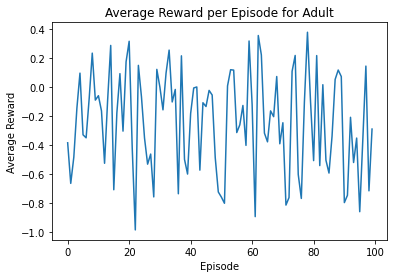

In [17]:
plot_reward(avg_reward_adult, "Adult")


In [18]:
agent_adolescent = setup_ddqn_agent(env_adolescent)
agent_adolescent, avg_reward_adolescent = train(env_adolescent, agent_adolescent)


state_size 3
action_size 7
buffer filled with random actions
Episode 1, Total Reward: 24.30000000000008, Average Reward: 0.11853658536585404
Episode 2, Total Reward: -20.100000000000005, Average Reward: -0.18611111111111114
Episode 3, Total Reward: 11.300000000000026, Average Reward: 0.0588541666666668
Episode 4, Total Reward: -9.09999999999999, Average Reward: -0.05290697674418599
Episode 5, Total Reward: -89.89999999999986, Average Reward: -0.3057823129251696
Episode 6, Total Reward: 57.0000000000002, Average Reward: 0.0959595959595963
Episode 7, Total Reward: 68.39999999999961, Average Reward: 0.13930753564154708
Episode 8, Total Reward: -62.29999999999995, Average Reward: -0.399358974358974
Episode 9, Total Reward: 4.4000000000000785, Average Reward: 0.01075794621026914
Episode 10, Total Reward: -2499.2999999999993, Average Reward: -0.1571689095711231
Episode 11, Total Reward: 15.600000000000001, Average Reward: 0.08863636363636364
Episode 12, Total Reward: -7.0999999999999375, Ave

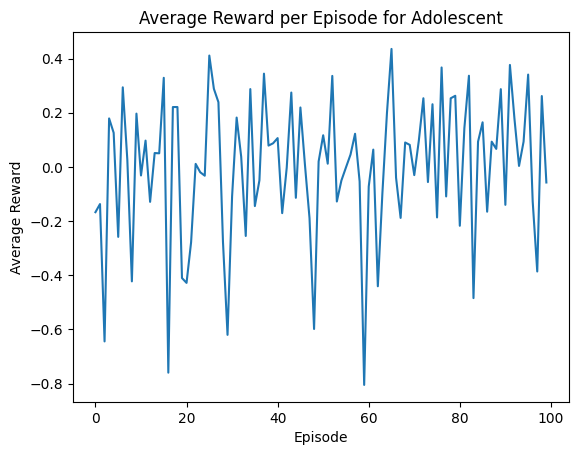

In [20]:
plot_reward(avg_reward_adolescent, "Adolescent")

In [20]:
agent_child = setup_ddqn_agent(env_child)
agent_child, avg_reward_child = train(env_child, agent_child)

state_size 3
action_size 7
buffer filled with random actions
Episode 1, Total Reward: 57.40000000000002, Average Reward: 0.2014035087719299
Episode 2, Total Reward: -147.39999999999992, Average Reward: -0.5849206349206346
Episode 3, Total Reward: -81.19999999999993, Average Reward: -0.7449541284403663
Episode 4, Total Reward: 91.79999999999993, Average Reward: 0.30599999999999977
Episode 5, Total Reward: 7.199999999999982, Average Reward: 0.03850267379679135
Episode 6, Total Reward: 47.30000000000011, Average Reward: 0.17262773722627778
Episode 7, Total Reward: -22.50000000000001, Average Reward: -0.32142857142857156
Episode 8, Total Reward: 19.400000000000052, Average Reward: 0.11901840490797577
Episode 9, Total Reward: -34.799999999999976, Average Reward: -0.14745762711864396
Episode 10, Total Reward: -63.39999999999986, Average Reward: -0.15889724310776907
Episode 11, Total Reward: -35.100000000000016, Average Reward: -0.1581081081081082
Episode 12, Total Reward: 1.799999999999997, 

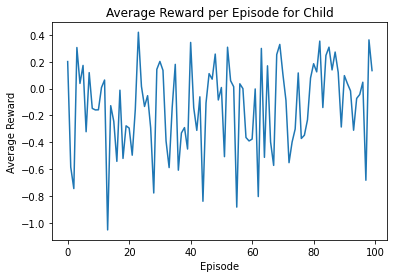

In [21]:
plot_reward(avg_reward_child, "Child")

/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Average Reward: -0.40


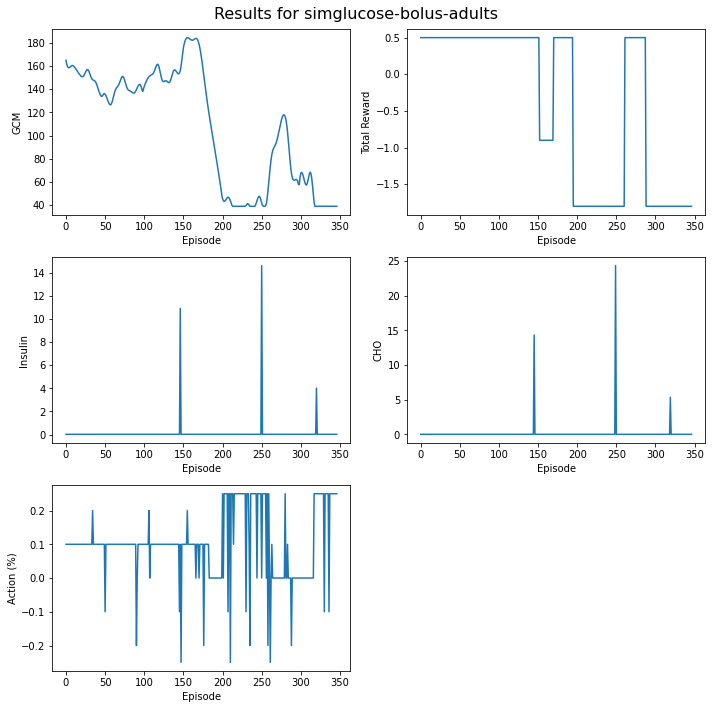

Results for simglucose-bolus-adults
Time in Range (TIR): 58.789625360230545%
Time Below Range (TBR): 36.023054755043226%
Time Above Range (TAR): 5.187319884726225%



/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Average Reward: -0.49


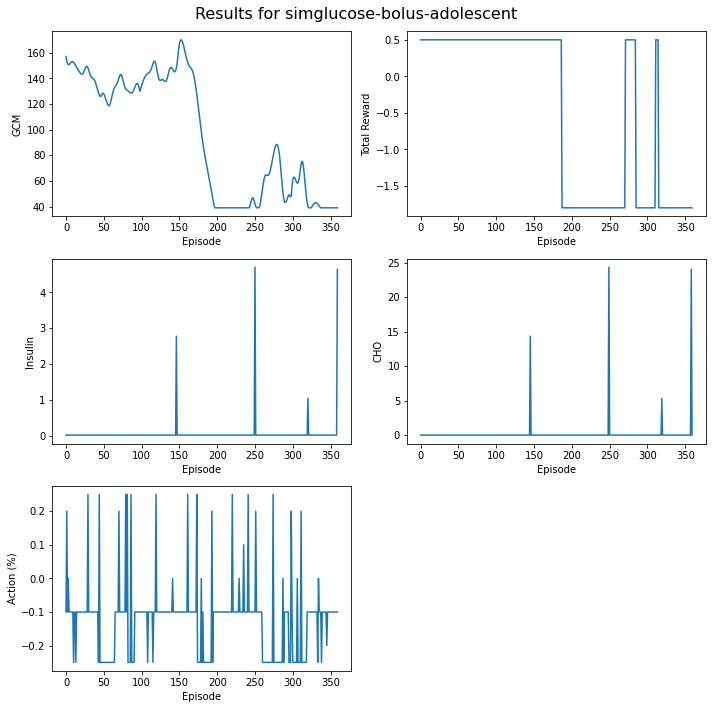

Results for simglucose-bolus-adolescent
Time in Range (TIR): 56.94444444444444%
Time Below Range (TBR): 43.05555555555556%
Time Above Range (TAR): 0.0%



/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Average Reward: -0.40


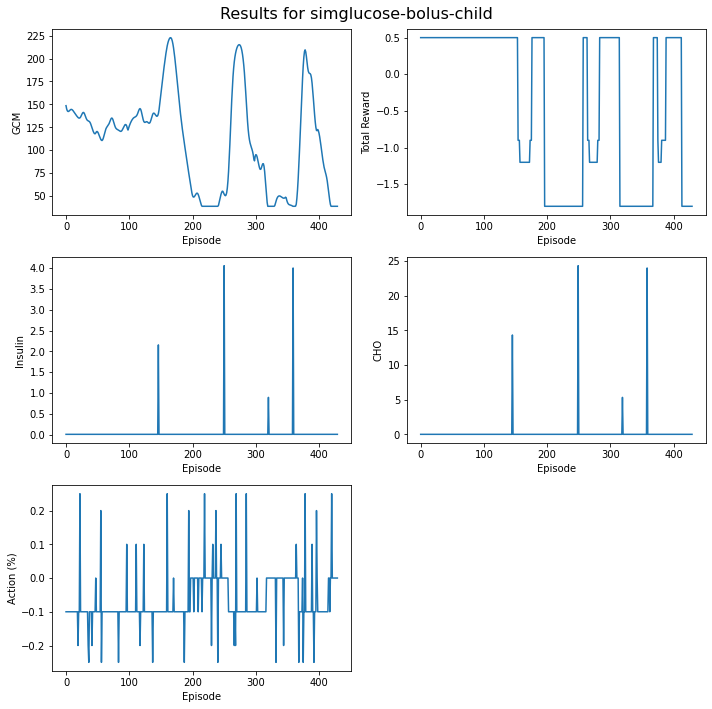

Results for simglucose-bolus-child
Time in Range (TIR): 56.97674418604651%
Time Below Range (TBR): 30.465116279069765%
Time Above Range (TAR): 12.558139534883722%



In [23]:
for agent, env_name in [
    (agent_adult, "simglucose-bolus-adults"),
    (agent_adolescent, "simglucose-bolus-adolescent"),
    (agent_child, "simglucose-bolus-child"),
]:  
    # Evaluate the agent
    memory, avg_reward = evaluate_policy(agent, env_name, seed=0, max_timesteps=800)
    print(f"Average Reward: {avg_reward:.2f}")

    # visualize results from the memory
    plt.figure(figsize=(10, 10))
    #set overall title
    plt.suptitle(f"Results for {env_name}", fontsize=16)
    plt.subplot(3, 2, 1)
    gcm_values = [transition.state[0] for transition in memory.memory]

    plt.plot(gcm_values)
    plt.xlabel("Episode")
    plt.ylabel("GCM")

    plt.subplot(3, 2, 2)
    rewards = [transition.reward for transition in memory.memory]

    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    plt.subplot(3, 2, 3)
    insulin_values = [transition.state[2] for transition in memory.memory]

    plt.plot(insulin_values)
    plt.xlabel("Episode")
    plt.ylabel("Insulin")

    plt.subplot(3, 2, 4)
    cho_values = [transition.state[1] for transition in memory.memory]

    plt.plot(cho_values)
    plt.xlabel("Episode")
    plt.ylabel("CHO")

    plt.subplot(3, 2, 5)
    # visualize the actions taken
    actions_idx = [transition.action for transition in memory.memory]

    actions_percentage = np.array([0.75, 0.8, 0.9, 1, 1.1, 1.2, 1.25]) - 1
    actions = actions_percentage[actions_idx]

    plt.plot(actions)
    plt.xlabel("Episode")
    plt.ylabel("Action (%)")

    plt.tight_layout()
    plt.show()
    #'state', 'action', 'next_state', 'reward', 'done', 'episode'

    tir, tbr, tar = calculate_metrics(memory)
    print(f"Results for {env_name}")
    print(f'Time in Range (TIR): {tir}%')
    print(f'Time Below Range (TBR): {tbr}%')
    print(f'Time Above Range (TAR): {tar}%')
    print()

#### baseline calculation


In [12]:
adolescents = [f"adolescent#{i:03d}" for i in range(1, 11)]
child = [f"child#{i:03d}" for i in range(1, 11)]
adults = [f"adult#{i:03d}" for i in range(1, 11)]


gym.envs.register(
    id="simglucose-bolus-adolescent-baseline",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": adolescents,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-child-baseline",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": child,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)
gym.envs.register(
    id="simglucose-bolus-adults-baseline",
    entry_point="simglucose.envs:T1DSimEnvBolus",
    kwargs={
        "patient_name": adults,
        "reward_fun": paper_reward_function,
        "history_length": 1,
        "enable_meal": True,
    },
)

In [14]:
num_episodes = 100
replay_memory_size = 800	

def baseline(env, agent):
    #fill buffer with constant action. actions go from -25 to 25, 
    #so the middle action (3) is 0 and therefore constant
    state, _ = env.reset()
    for i in range(replay_memory_size):    
        action = 3	
        next_state, reward, done, _, info = env.step(action)
        agent.store_transition(state, action, reward, next_state, done)
        state = next_state
        if done:
            state, _ = env.reset()
    print('buffer filled with constant action')

    

    return agent

    

In [15]:
for env_name in [
    ("simglucose-bolus-adults-baseline"),
    ("simglucose-bolus-adolescent-baseline"),
    ("simglucose-bolus-child-baseline"),
]:
    # baseline agent with child env
    env_baseline = create_env(env_name)
    agent_baseline = setup_ddqn_agent(env_baseline)
    agent_baseline = baseline(env_baseline, agent_baseline)

    # Evaluate the agent
    memory, avg_reward = evaluate_policy(
        agent_baseline,
        env_name,
        seed=0,
        max_timesteps=800,
        baseline=True,
    )
    print(f"Average Reward for {env_name}: {avg_reward:.2f}")
    tir, tbr, tar = calculate_metrics(memory)
    print(f"Results for baseline {env_name} env")
    print(f"Time in Range (TIR): {tir}%")
    print(f"Time Below Range (TBR): {tbr}%")
    print(f"Time Above Range (TAR): {tar}%")
    print()

state_size 5
action_size 7
buffer filled with constant action


c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Average Reward for simglucose-bolus-adults-baseline: -0.38
Results for baseline simglucose-bolus-adults-baseline env
Time in Range (TIR): 59.48275862068966%
Time Below Range (TBR): 35.05747126436782%
Time Above Range (TAR): 5.459770114942529%

state_size 5
action_size 7
buffer filled with constant action


c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Average Reward for simglucose-bolus-adolescent-baseline: -0.00
Results for baseline simglucose-bolus-adolescent-baseline env
Time in Range (TIR): 78.05907172995781%
Time Below Range (TBR): 21.940928270042196%
Time Above Range (TAR): 0.0%

state_size 5
action_size 7
buffer filled with constant action


c:\Users\Mena Lerf\anaconda3\envs\rl_sim\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Average Reward for simglucose-bolus-child-baseline: -0.40
Results for baseline simglucose-bolus-child-baseline env
Time in Range (TIR): 57.20930232558139%
Time Below Range (TBR): 30.697674418604652%
Time Above Range (TAR): 12.093023255813954%

